#### Montar pasta do Google Drive ####

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Imports e pip ####

In [48]:
!pip install transformers
!pip install imbalanced-learn
!pip install pandas
!pip install nltk
!pip install mlxtend
!pip install xgboost

     -------------------------------------- 106.6/106.6 MB 7.1 MB/s eta 0:00:00


In [77]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import re

from sklearn.model_selection import train_test_split, cross_val_predict, cross_validate, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 
# from sklearn.model_selection import 

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.feature_extraction.text import 
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
# from sklearn.ensemble import 
# from sklearn.ensemble import 

from xgboost.sklearn import XGBClassifier


from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import svm, metrics
# from sklearn import 
from matplotlib import pyplot
from scipy.stats import loguniform
from IPython.display import display
# from mlxtend.evaluate import confusion_matrix
# from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from matplotlib import pyplot as plt

In [5]:
# termos muito frequentes que não tem relevância nos dados. São palavras que possuem apenas significado sintático dentro da sentença, porém não trazem informações relevantes sobre o seu sentido.
nltk.download('stopwords')
# RSLP Stemmer (Removedor de Sufixos da Lingua Portuguesa)
nltk.download('rslp')
# punkt é um tokenizer 
nltk.download('punkt')
# dicionário de léxicos (conjunto de vocabulários de determinado idioma) e hierarquia de termos
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wills\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

#### Carregar os dados nos dataframes ####

In [6]:
df_teste = pd.read_csv('../dataset/teste.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_treino = pd.read_csv('../dataset/treino.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df_validacao = pd.read_csv('../dataset/validacao.csv', sep=';', names=('texto', 'emocao'), encoding='utf-8', header=None)
df = pd.concat([df_treino, df_teste, df_validacao])

#### Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)

In [7]:
df.count()

texto     20004
emocao    19995
dtype: int64

In [8]:
df.head(3)

,texto,emocao
0,não me senti humilhado,tristeza
1,posso passar de me sentindo tão sem esperança ...,tristeza
2,estou pegando um minuto para postar me sinto g...,raiva


<AxesSubplot:>

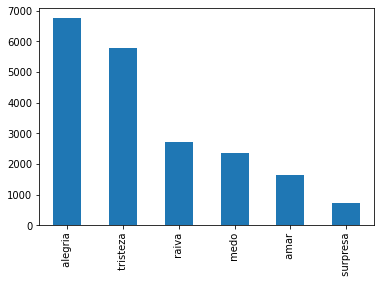

In [9]:
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

#### Feature Engineer:

* Análise dos dados (tamanho dataset, valores para emoção, dados nulos/NaN)
* Remover valores nulos/NAN
* Remover linhas duplicadas

In [10]:
df.isna().sum()

texto     0
emocao    9
dtype: int64

In [11]:
df = df.dropna()

In [12]:
df.isna().sum()

texto     0
emocao    0
dtype: int64

In [13]:
df.count()

texto     19995
emocao    19995
dtype: int64

In [14]:
df = df.drop_duplicates(['texto'])

In [15]:
df.count()

texto     19918
emocao    19918
dtype: int64

#### Defini funções para pre processamento

In [16]:
pontuacao = list(string.punctuation)

In [17]:
def exclui_palavras_irrelevantes(texto):
    stops = set(stopwords.words('portuguese') + pontuacao)
    palavras = [i for i in texto.split() if not i in stops]
    return (" ".join(palavras))

In [18]:
def exclui_radicais(texto):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in texto.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [19]:
def exclui_pontuacao(texto):
    palavras = [i for i in texto if not i in pontuacao]
    return ("".join(palavras))

In [20]:
def lemmatization(instancia):
    wordnet_lemmatizer = WordNetLemmatizer()
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))


#### Aplica as funções de pre-processamento nos dados e split Train / Test dataset

* Avaliar o uso do Stemming (remove o radical das palavras (Ex. altera frequentemente para frenquent, imediatamente para imediat), isso pode trazer um problema pois ele pode gerar palavras que não existem no idioma.
* Avaliar o uso do Lemmatization (Ex. uma forma de Stemming que mantém a palavra com significado real (Ex. altera frequentemente para frenquente, imediatamente para imediato). O problema dessa abordagem, é que o Lemmatizer do NLTK utiliza o Dicionário da WordNet que não é específico para o Portugues

In [25]:
def pre_processing(texto, show_results=False):
    stemmer = exclui_radicais(texto.lower())
    pont = exclui_pontuacao(stemmer)
    stops = exclui_palavras_irrelevantes(pont)
    lemma = lemmatization(stops)
    # palavras = [stemmer.stem(i) for i in instancia.split() if not i in stops]
    if(show_results):
        print('Original text: {}'.format(texto))
        print('Stemmer aplicado: {}'.format(stemmer))
        print('Exclusao de pontuação aplicado: {}'.format(pont))
        print('Exclusao de stopwords aplicado: {}'.format(stops))
    return ("".join(lemma))

In [26]:
# Analise sobre possível desbalanceamento de classes
df['emocao'].value_counts()

 alegria     6735
 tristeza    5779
 raiva       2698
 medo        2365
 amar        1629
 surpresa     712
Name: emocao, dtype: int64

<AxesSubplot:>

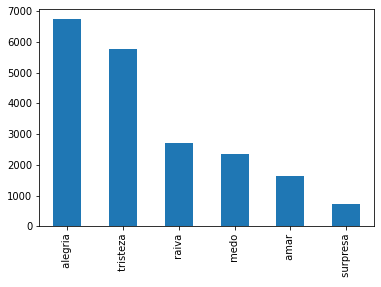

In [27]:
# Analise sobre possível desbalanceamento de classes
%matplotlib inline
df['emocao'].value_counts().plot(kind='bar')

In [28]:
# aplicando os processos de tratamento nos texto (retirada de pontuação, stopwords, stemmer e lemmatization)
X = [pre_processing(i) for i in df['texto']]

In [29]:
labelencoder = LabelEncoder()
df['emocao_encoded'] = labelencoder.fit_transform(df['emocao'])

X_train, X_test, y_train, y_test = train_test_split(pd.Series(X), df['emocao_encoded'], random_state=41, test_size=0.2, stratify=df['emocao_encoded'])

# Com o uso do Undersampler a performce do modelo piora, muito provavelmente devido a grande diminuição de dados
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(pd.DataFrame(X), df['emocao_encoded'])
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under.squeeze(), y_under, random_state=41, test_size=0.2, stratify=y_under)

In [30]:
type(df['emocao_encoded'])
# X_test

pandas.core.series.Series

In [31]:
df[['emocao','emocao_encoded']].drop_duplicates()

,emocao,emocao_encoded
0,tristeza,5
2,raiva,3
3,amar,1
6,surpresa,4
7,medo,2
8,alegria,0


<AxesSubplot:>

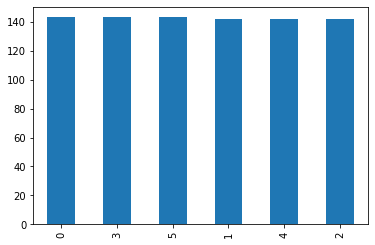

In [32]:
# analisando o resultado da aplicação de undersampler nas classes para ficarem próximas ao da classe minoritária
%matplotlib inline
y_test_under.value_counts().plot(kind='bar')

#### Tokenização - Importante. Por não se tratar de uma análise de dados recuperados da internet, onde existe um linguajar específico onde é usado emoticons, hashtag, emojis e etc, para essa análise não precisamos utilizar o Tokenizer do Tweeter para tratar esse tipo de linguajar. Podemos usar o Tokenizer de palavras normais e entender que o espaço é o suficiente para separar as palavras sem afetar o sentido do textos

#### Frases e Predições de teste

In [33]:
testes = ['eu posso ter para um deleite ou se estou me sentindo festivo',
          'estou me sentindo muito triste e com pena de mim mesma, mas logo vou me livrar disso',
          'estou apenas me sentindo mal-humorada e azul ',
          'só sei que, para começar, vou me sentir tímido com isso',
          'eu também adorei que você pudesse realmente sentir o desespero nessas sequências e eu gostei especialmente da emoção entre cavaleiro e escudeiro, já que eles estão juntos de maneira semelhante a batman e robin há muito tempo',
          'estou me sentindo um pouco atordoada com a quantidade de itens que não uso mais para decoração']

predicao_correta = ['alegria', 'tristeza', 'raiva', 'medo', 'amar', 'surpresa']

In [34]:
testes = [pre_processing(i) for i in testes]

In [35]:
# Transforma os dados de teste em vetores de palavras.
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)
texto_teste_vetorizado = tfidf_vectorizer.transform(testes)

#### Vetorização dos textos

*   CountVectorizer: [BagOfWords Model] - É uma representação numérica de uma fração do texto que facilita a classificação, dessa forma o algoritmo conta a frequnência com que a palavra aparece no texto e cria um dicionário disso. Isso é chamado de Tokenization in NLP (Natural Language Processing). O CountVectorizer realiza esse processo
*   TfidfVectorizer: Transforma texto em vetores de recursos que podem ser usados ​​como entrada para o estimador



In [36]:
def get_vectorize_instance(vectorize_name):
    if(vectorize_name == 'CountVectorizer'):
        return CountVectorizer(analyzer="word")
    elif(vectorize_name == 'TfidfVectorizer'):
        return TfidfVectorizer()
    else:
        raise Exception("Vectorizer not found!")

In [37]:
def vectorize_dataframe(vectorizer, X_train, X_test):
    if(type(vectorizer) is CountVectorizer):
        train_data = vectorizer.fit_transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    elif (type(vectorizer) is TfidfVectorizer):
        vectorizer.fit(X_train)
        train_data = vectorizer.transform(X_train)
        test_data = vectorizer.transform(X_test)
        return train_data, test_data
    else:
        raise Exception("Vectorizer type incorrect!")

In [38]:
def train_model(modelo, X_train, y_train):
    return modelo.fit(X_train, y_train)

In [39]:
def predict_model(modelo, X_test):
    return modelo.predict(X_test)

In [40]:
def score_model(modelo, X_test, y_test):
    return modelo.score(X_test, y_test)

In [41]:
def plot_predict_right(X_test, predictions, right_predictions, num_rows=5):
    pred = pd.DataFrame({'predição modelo': predictions, 'predição correta': right_predictions})
    display(pred[:num_rows])

In [42]:
def plot_classification_report(y_test, y_pred):
    print(metrics.classification_report(y_test, y_pred))

In [43]:
def plot_confusion_matrix_graph(y_test, y_pred):
    cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=False, show_normed=True, figsize=(10, 10))
    plt.show()

In [44]:
def evaluates_score_model(modelo, vectorizer, X_train, X_test, y_train, y_test):
    print('#######################################################################################################################################')
    print('##### Avaliando Modelo {} / Vectorizer {} #####'.format(modelo, vectorizer))
    train_vectorized, test_vectorized = vectorize_dataframe(vectorizer, X_train, X_test)
    model = train_model(modelo, train_vectorized, y_train)
    y_pred = predict_model(modelo, test_vectorized)
    print('Accuracy do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.accuracy_score(y_test, y_pred))))
    print('Precision do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.precision_score(y_test, y_pred, average='macro'))))
    print('Recall do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.recall_score(y_test, y_pred, average='macro'))))
    print('F1-Score do Modelo {} com Vectorizer {} é de {:.3f}'.format(modelo, vectorizer, float(metrics.f1_score(y_test, y_pred, average='macro'))))
    plot_predict_right(X_test, y_pred, y_test)
    plot_classification_report(y_test, y_pred)
#     plot_confusion_matrix_graph(y_test, y_pred)
    print('\n')
    return modelo, vectorizer, y_pred

In [60]:
# 'XGBClassifier': XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective='multi:softmax', nthread=4, num_class=6, seed=27)),

classifiers = {
        'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
        'MultinomialNB': MultinomialNB(),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
        'SVC': SVC(kernel='linear'),
        'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
        'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
        'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
        'AdaBoostClassifier': AdaBoostClassifier(),
        'XGBClassifier': XGBClassifier(objective='multi:softmax', num_class=6),
        'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
    }

In [51]:
def get_model_instace(model):
    return classifiers.get(model) 

In [57]:
list_models = [get_model_instace('LogisticRegression')
                ,get_model_instace('MultinomialNB')
                ,get_model_instace('RandomForestClassifier')
                ,get_model_instace('SVC')
                ,get_model_instace('SGDClassifier')
                ,get_model_instace('DecisionTreeClassifier')
                ,get_model_instace('KNeighborsClassifier')
                ,get_model_instace('AdaBoostClassifier')
                ,get_model_instace('XGBClassifier')
                ,get_model_instace('GradientBoostingClassifier')]

list_vectors_instance = [get_vectorize_instance('CountVectorizer'), get_vectorize_instance('TfidfVectorizer')]

In [53]:
def evaluates_all_models(list_models, list_vectors_instance):
    modelos = []
    vectorizers = []
    y_predictions = []
    for m in list_models:
        for vec in list_vectors_instance:
            modelo, vec, y_pred = evaluates_score_model(m, vec, X_train_under, X_test_under, y_train_under, y_test_under)
            modelos.append(modelo), y_predictions.append(y_pred), vectorizers.append(vec)
#             d[modelo] = y_pred
    print('##### Fim avaliação #####')
    return modelos, vectorizers, y_predictions

In [94]:
def plot_all_confusion_matrix(modelos, vectorizers, y_test, y_predictions):
    '''
    Método responsável por plotar a matriz de confusão dos modelos passados via parametro
    '''
    cols = 4
    rows = 5 
    
    f, axes = plt.subplots(rows, cols, figsize=(60, 50), sharey='row')

    idx_col = 0
    idx_row = 0

    font = {'family' : 'monospace', 'weight' : 'bold', 'size' : 40}
    
    for m, v, y in zip(modelos, vectorizers, y_predictions):

        cm = confusion_matrix(y_test, y, labels = m.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = m.classes_)
        
        if(idx_col == cols):
            idx_row = idx_row + 1
            idx_col = 0
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1
        else:
            disp.plot(ax=axes[idx_row, idx_col], xticks_rotation=5)
            idx_col = idx_col + 1

        disp.ax_.set_title('{} - {}'.format(str(type(m).__name__), str(v)[0:5]))
        disp.im_.colorbar.remove()
    #     disp.ax_.set_xlabel('')
    #     if i!=0:
    #         disp.ax_.set_ylabel('')

    f.text(x=0.4, y=0.1, 'Predição', horizontalalignment='left')
#     plt.subplots_adjust(wspace=0.40, hspace=0.1)
    plt.subplots_adjust(wspace=0.9, hspace=.40)
    plt.rc('font', **font)

    # f.colorbar(disp.im_, ax=axes)
    # f.colorbar().remove()
    plt.show()

In [61]:
# executa o método que fará a avaliação dos modelos
modelos, vectorizers, y_predictions = evaluates_all_models(list_models, list_vectors_instance)

#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer CountVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.705
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.708
Recall do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.705
F1-Score do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer CountVectorizer() é de 0.706


C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.57      0.66      0.61       143
           1       0.71      0.66      0.69       142
           2       0.75      0.70      0.72       142
           3       0.75      0.73      0.74       143
           4       0.84      0.87      0.86       142
           5       0.64      0.59      0.62       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo LogisticRegression(multi_class='multinomial') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 0.697
Precision do Modelo LogisticRegression(multi_class='multinomial') com Vectorizer TfidfVectorizer() é de 

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.59      0.64      0.62       143
           1       0.66      0.68      0.67       142
           2       0.74      0.70      0.72       142
           3       0.74      0.74      0.74       143
           4       0.85      0.86      0.85       142
           5       0.61      0.57      0.59       143

    accuracy                           0.70       855
   macro avg       0.70      0.70      0.70       855
weighted avg       0.70      0.70      0.70       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer CountVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.621
Precision do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.617
Recall do Modelo MultinomialNB() com Vectorizer CountVectorizer() é de 0.621
F1-Scor

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,1,4


              precision    recall  f1-score   support

           0       0.57      0.54      0.55       143
           1       0.59      0.58      0.58       142
           2       0.59      0.66      0.62       142
           3       0.67      0.69      0.68       143
           4       0.71      0.82      0.76       142
           5       0.57      0.44      0.50       143

    accuracy                           0.62       855
   macro avg       0.62      0.62      0.62       855
weighted avg       0.62      0.62      0.62       855



#######################################################################################################################################
##### Avaliando Modelo MultinomialNB() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.673
Precision do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.671
Recall do Modelo MultinomialNB() com Vectorizer TfidfVectorizer() é de 0.673
F1-Scor

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,4,4


              precision    recall  f1-score   support

           0       0.64      0.62      0.63       143
           1       0.64      0.62      0.63       142
           2       0.66      0.71      0.68       142
           3       0.72      0.72      0.72       143
           4       0.72      0.84      0.77       142
           5       0.66      0.53      0.59       143

    accuracy                           0.67       855
   macro avg       0.67      0.67      0.67       855
weighted avg       0.67      0.67      0.67       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.702
Precision do Modelo RandomForestClassifier() com Vectorizer CountVectorizer() é de 0.707
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.60      0.64      0.62       143
           1       0.69      0.65      0.67       142
           2       0.82      0.70      0.76       142
           3       0.77      0.69      0.73       143
           4       0.78      0.92      0.85       142
           5       0.57      0.61      0.59       143

    accuracy                           0.70       855
   macro avg       0.71      0.70      0.70       855
weighted avg       0.71      0.70      0.70       855



#######################################################################################################################################
##### Avaliando Modelo RandomForestClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.667
Precision do Modelo RandomForestClassifier() com Vectorizer TfidfVectorizer() é de 0.669
Recall do Modelo RandomForestClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.53      0.59      0.56       143
           1       0.65      0.69      0.67       142
           2       0.77      0.67      0.71       142
           3       0.76      0.65      0.70       143
           4       0.77      0.92      0.84       142
           5       0.53      0.49      0.51       143

    accuracy                           0.67       855
   macro avg       0.67      0.67      0.67       855
weighted avg       0.67      0.67      0.66       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.682
Precision do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer() é de 0.690
Recall do Modelo SVC(kernel='linear') com Vectorizer CountVectorizer(

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.53      0.67      0.59       143
           1       0.65      0.66      0.66       142
           2       0.79      0.65      0.71       142
           3       0.73      0.70      0.71       143
           4       0.79      0.87      0.83       142
           5       0.66      0.55      0.60       143

    accuracy                           0.68       855
   macro avg       0.69      0.68      0.68       855
weighted avg       0.69      0.68      0.68       855



#######################################################################################################################################
##### Avaliando Modelo SVC(kernel='linear') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.697
Precision do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer() é de 0.705
Recall do Modelo SVC(kernel='linear') com Vectorizer TfidfVectorizer(

,predição modelo,predição correta
1172,0,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.54      0.68      0.60       143
           1       0.65      0.68      0.66       142
           2       0.80      0.68      0.74       142
           3       0.75      0.71      0.73       143
           4       0.82      0.87      0.85       142
           5       0.65      0.57      0.61       143

    accuracy                           0.70       855
   macro avg       0.70      0.70      0.70       855
weighted avg       0.70      0.70      0.70       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer CountVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.715
Precision do Modelo SGDClassifier(loss='log') com Vectorizer CountVectorizer() é de 0.716
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.58      0.67      0.62       143
           1       0.72      0.63      0.67       142
           2       0.76      0.73      0.75       142
           3       0.76      0.76      0.76       143
           4       0.81      0.89      0.85       142
           5       0.66      0.61      0.64       143

    accuracy                           0.71       855
   macro avg       0.72      0.71      0.71       855
weighted avg       0.72      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo SGDClassifier(loss='log') / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.715
Precision do Modelo SGDClassifier(loss='log') com Vectorizer TfidfVectorizer() é de 0.715
Recall do Modelo SGDClassifier(loss='log') com Vectori

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,2,2
334,0,0
3321,0,4


              precision    recall  f1-score   support

           0       0.59      0.64      0.61       143
           1       0.70      0.70      0.70       142
           2       0.77      0.72      0.74       142
           3       0.76      0.76      0.76       143
           4       0.82      0.88      0.85       142
           5       0.65      0.60      0.63       143

    accuracy                           0.71       855
   macro avg       0.71      0.71      0.71       855
weighted avg       0.71      0.71      0.71       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.646
Precision do Modelo DecisionTreeClassifier() com Vectorizer CountVectorizer() é de 0.648
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.49      0.59      0.54       143
           1       0.62      0.59      0.60       142
           2       0.72      0.70      0.71       142
           3       0.67      0.63      0.65       143
           4       0.77      0.87      0.81       142
           5       0.62      0.50      0.55       143

    accuracy                           0.65       855
   macro avg       0.65      0.65      0.64       855
weighted avg       0.65      0.65      0.64       855



#######################################################################################################################################
##### Avaliando Modelo DecisionTreeClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.586
Precision do Modelo DecisionTreeClassifier() com Vectorizer TfidfVectorizer() é de 0.598
Recall do Modelo DecisionTreeClassifier() com Vectorizer 

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.38      0.41      0.39       143
           1       0.56      0.59      0.58       142
           2       0.76      0.64      0.69       142
           3       0.73      0.64      0.68       143
           4       0.76      0.81      0.78       142
           5       0.39      0.43      0.41       143

    accuracy                           0.59       855
   macro avg       0.60      0.59      0.59       855
weighted avg       0.60      0.59      0.59       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.297
Precision do Modelo KNeighborsClassifier() com Vectorizer CountVectorizer() é de 0.311
Recall do Modelo KNeighborsClassifier() com Vectorizer CountVec

,predição modelo,predição correta
1172,5,1
3407,2,4
1552,2,2
334,1,0
3321,3,4


              precision    recall  f1-score   support

           0       0.24      0.29      0.26       143
           1       0.23      0.28      0.26       142
           2       0.32      0.32      0.32       142
           3       0.28      0.22      0.25       143
           4       0.51      0.38      0.44       142
           5       0.27      0.29      0.28       143

    accuracy                           0.30       855
   macro avg       0.31      0.30      0.30       855
weighted avg       0.31      0.30      0.30       855



#######################################################################################################################################
##### Avaliando Modelo KNeighborsClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.572
Precision do Modelo KNeighborsClassifier() com Vectorizer TfidfVectorizer() é de 0.580
Recall do Modelo KNeighborsClassifier() com Vectorizer TfidfVec

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,2,0
3321,4,4


              precision    recall  f1-score   support

           0       0.49      0.63      0.55       143
           1       0.55      0.52      0.53       142
           2       0.57      0.63      0.60       142
           3       0.60      0.57      0.58       143
           4       0.61      0.70      0.65       142
           5       0.65      0.39      0.49       143

    accuracy                           0.57       855
   macro avg       0.58      0.57      0.57       855
weighted avg       0.58      0.57      0.57       855



#######################################################################################################################################
##### Avaliando Modelo AdaBoostClassifier() / Vectorizer CountVectorizer() #####
Accuracy do Modelo AdaBoostClassifier() com Vectorizer CountVectorizer() é de 0.253
Precision do Modelo AdaBoostClassifier() com Vectorizer CountVectorizer() é de 0.413
Recall do Modelo AdaBoostClassifier() com Vectorizer CountVectorizer(

,predição modelo,predição correta
1172,5,1
3407,4,4
1552,1,2
334,1,0
3321,1,4


              precision    recall  f1-score   support

           0       0.12      0.08      0.09       143
           1       0.21      0.86      0.33       142
           2       0.43      0.21      0.28       142
           3       0.77      0.12      0.21       143
           4       0.78      0.20      0.31       142
           5       0.16      0.06      0.08       143

    accuracy                           0.25       855
   macro avg       0.41      0.25      0.22       855
weighted avg       0.41      0.25      0.22       855



#######################################################################################################################################
##### Avaliando Modelo AdaBoostClassifier() / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo AdaBoostClassifier() com Vectorizer TfidfVectorizer() é de 0.237
Precision do Modelo AdaBoostClassifier() com Vectorizer TfidfVectorizer() é de 0.335
Recall do Modelo AdaBoostClassifier() com Vectorizer TfidfVectorizer(

,predição modelo,predição correta
1172,0,1
3407,4,4
1552,1,2
334,1,0
3321,1,4


              precision    recall  f1-score   support

           0       0.11      0.08      0.09       143
           1       0.20      0.77      0.31       142
           2       0.43      0.20      0.28       142
           3       0.42      0.14      0.21       143
           4       0.70      0.18      0.29       142
           5       0.15      0.06      0.08       143

    accuracy                           0.24       855
   macro avg       0.33      0.24      0.21       855
weighted avg       0.33      0.24      0.21       855



#######################################################################################################################################
##### Avaliando Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_class=9,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=27, subsample=0.8, tree_method='exact', ...) com Vectorizer CountVectorizer() é de 0.723
Precision do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_cons

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.61      0.63      0.62       143
           1       0.70      0.70      0.70       142
           2       0.80      0.75      0.77       142
           3       0.77      0.73      0.75       143
           4       0.82      0.91      0.86       142
           5       0.63      0.63      0.63       143

    accuracy                           0.72       855
   macro avg       0.72      0.72      0.72       855
weighted avg       0.72      0.72      0.72       855



#######################################################################################################################################
##### Avaliando Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step

C:\Users\wills\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_class=9,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              seed=27, subsample=0.8, tree_method='exact', ...) com Vectorizer TfidfVectorizer() é de 0.691
Precision do Modelo XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_cons

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.57      0.59      0.58       143
           1       0.64      0.66      0.65       142
           2       0.76      0.73      0.74       142
           3       0.78      0.70      0.74       143
           4       0.82      0.92      0.87       142
           5       0.57      0.55      0.56       143

    accuracy                           0.69       855
   macro avg       0.69      0.69      0.69       855
weighted avg       0.69      0.69      0.69       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer CountVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.722
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer CountVectorizer() é de 0.7

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.49      0.71      0.58       143
           1       0.74      0.68      0.71       142
           2       0.85      0.72      0.78       142
           3       0.83      0.73      0.77       143
           4       0.79      0.94      0.86       142
           5       0.77      0.56      0.65       143

    accuracy                           0.72       855
   macro avg       0.74      0.72      0.72       855
weighted avg       0.74      0.72      0.72       855



#######################################################################################################################################
##### Avaliando Modelo GradientBoostingClassifier(n_estimators=150) / Vectorizer TfidfVectorizer() #####
Accuracy do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.729
Precision do Modelo GradientBoostingClassifier(n_estimators=150) com Vectorizer TfidfVectorizer() é de 0.7

,predição modelo,predição correta
1172,1,1
3407,4,4
1552,2,2
334,1,0
3321,4,4


              precision    recall  f1-score   support

           0       0.55      0.71      0.62       143
           1       0.72      0.72      0.72       142
           2       0.85      0.70      0.77       142
           3       0.81      0.73      0.77       143
           4       0.79      0.94      0.86       142
           5       0.71      0.57      0.63       143

    accuracy                           0.73       855
   macro avg       0.74      0.73      0.73       855
weighted avg       0.74      0.73      0.73       855



##### Fim avaliação #####


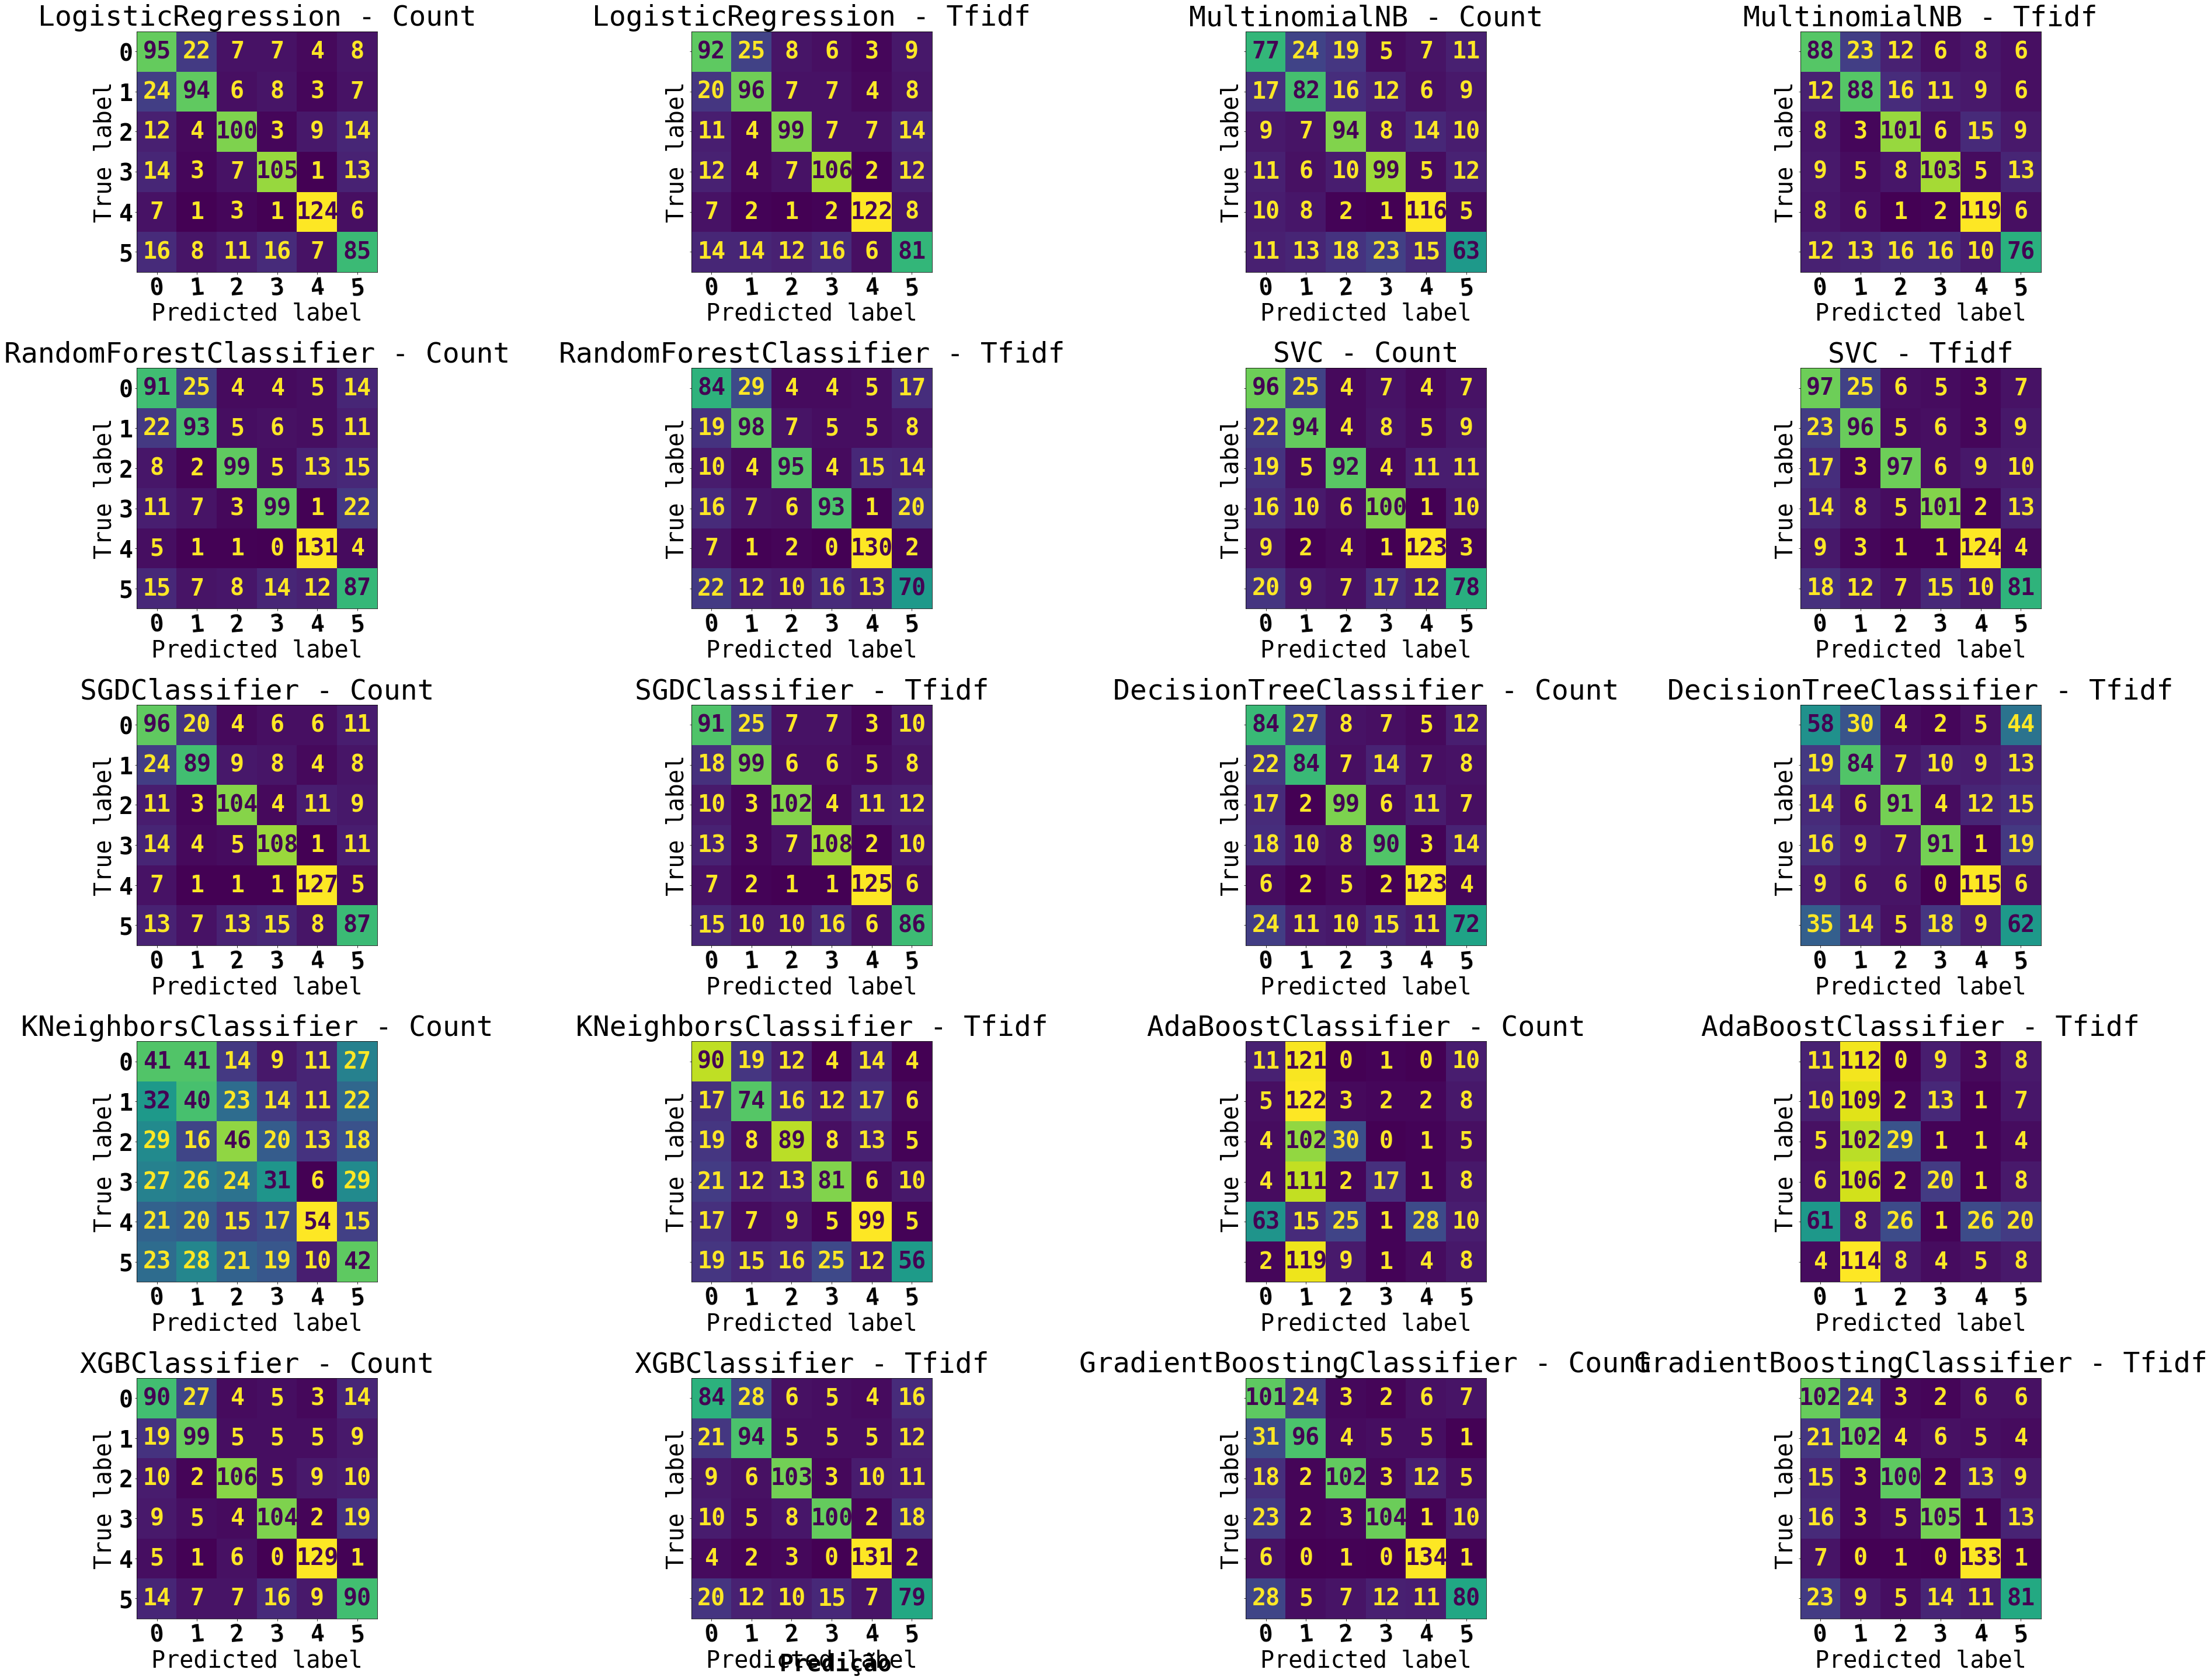

In [95]:
plot_all_confusion_matrix(modelos, vectorizers, y_test_under, y_predictions)

In [ ]:
# from sklearn.metrics import plot_confusion_matrix as ppp
# from matplotlib import pyplot as plt

# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,10))

# v = TfidfVectorizer()
# v.fit(X_test)
# X_test_data_vec = v.transform(X_test)

# svc = SVC()
# svc.fit(X_test_data_vec, y_test)

# ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')

# # # print(axes.flatten())

# for cls, ax in zip(list_models, axes.flatten()):
# #     ppp(cls, X_test_data_vec, y_test, ax=ax, cmap='Blues', display_labels=y_test)
#     ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # from sklearn.metrics import plot_confusion_matrix as ppp
# from matplotlib import pyplot as plt

# fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

# v = TfidfVectorizer()
# v.fit(X_test)
# X_test_data_vec = v.transform(X_test)

# svc = SVC()
# svc.fit(X_test_data_vec, y_test)

# y_pred = predict_model(svc, X_test_data_vec)

# # ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')

# # # print(axes.flatten())

# for bb, ax in zip(list_models, axes.flatten()):
# #     ppp(cls, X_test_data_vec, y_test, ax=ax, cmap='Blues', display_labels=y_test)
#     cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
#     disp.plot()
# #     plt.show()
# #     ppp(svc, X_test_data_vec, y_test, ax=ax, cmap='Blues')
#     ax.title.set_text(type(bb).__name__)
# plt.tight_layout()  
# # plt.show()

In [ ]:
# rows = 2
# cols = 4
# f, axes = plt.subplots(rows, cols, figsize=(15, 10), sharey='row')

# v = TfidfVectorizer()
# v.fit(X_test)
# X_test_data_vec = v.transform(X_test)

# svc = SVC()
# svc.fit(X_test_data_vec, y_test)

# y_pred = predict_model(svc, X_test_data_vec)

# classifiers_aaa = {
#         'LogisticRegression': LogisticRegression(multi_class='multinomial', solver='lbfgs'),
#         'MultinomialNB': MultinomialNB(),
#         'RandomForestClassifier': RandomForestClassifier(n_estimators=100),
#         'SVC': SVC(kernel='linear'),
#         'SGDClassifier': SGDClassifier(loss="log", penalty="l2"),
#         'DecisionTreeClassifier': DecisionTreeClassifier(criterion="gini"),
#         'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
#         'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=150),
#     }

# cols_first_row = 0
# cols_second_row = 0

# # for i, (key, classifiers_aaa) in enumerate(classifiers_aaa):
# for i, l in enumerate(classifiers_aaa.items()):
#     cm = confusion_matrix(y_test, y_pred, labels=svc.classes_)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)

#     if(i > cols-1):
#         disp.plot(ax=axes[1,cols_second_row], xticks_rotation=5)
#         cols_second_row = cols_second_row + 1
#     else:
#         disp.plot(ax=axes[0,cols_first_row], xticks_rotation=5)
#         cols_first_row = cols_first_row + 1
        
#     disp.ax_.set_title(key)
#     disp.im_.colorbar.remove()
# #     disp.ax_.set_xlabel('')
# #     if i!=0:
# #         disp.ax_.set_ylabel('')

# # f.text(0.4, 0.1, 'Predicted label', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)

# # f.colorbar(disp.im_, ax=axes)
# # f.colorbar().remove()
# plt.show()

In [ ]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# space = dict()
# space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
# space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
# space['C'] = loguniform(1e-5, 100)

# search = RandomizedSearchCV(LogisticRegression(), space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# # search = GridSearchCV(..., scoring='accuracy', n_jobs=-1)

# train_vectorized, test_vectorized = vectorize_dataframe(get_vectorize_instance('TfidfVectorizer'), X_train, X_test)

# # execute search
# result = search.fit(train_vectorized, y_train)

# # summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)